In [1]:
# Update sklearn to prevent version mismatches
# !pip install sklearn --upgrade

## Dependencies

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymongo
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from config import mongo_conn

## Load Perfume Data

In [3]:
# Initialize PyMongo to work with MongoDBs
client = pymongo.MongoClient(mongo_conn)
db = client.perfumes_db
perfume_df = pd.DataFrame(list(db.perfume_data_coll.find()))
perfume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           478 non-null    object
 1   name          478 non-null    object
 2   company       478 non-null    object
 3   image         478 non-null    object
 4   for_gender    478 non-null    object
 5   rating        478 non-null    object
 6   number_votes  478 non-null    object
 7   main accords  478 non-null    object
 8   description   478 non-null    object
 9   top notes     478 non-null    object
 10  middle notes  478 non-null    object
 11  base notes    478 non-null    object
 12  longevity     478 non-null    object
 13  sillage       478 non-null    object
 14  gender_vote   478 non-null    object
 15  price value   478 non-null    object
dtypes: object(16)
memory usage: 59.9+ KB


## Preprocess Data

### MultiLabelBinarizer

In [4]:
# convert Notes list to multiple features columns
mlb = MultiLabelBinarizer()

# Top Notes
X_top_notes = mlb.fit_transform(perfume_df["top notes"])
column_names = ["top_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_top_notes, columns=column_names))

# Middle Notes
X_middle_notes = mlb.fit_transform(perfume_df["middle notes"])
column_names = ["middle_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_middle_notes, columns=column_names))

# Base notes
X_base_notes = mlb.fit_transform(perfume_df["base notes"])
column_names = ["base_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_base_notes, columns=column_names))

perfume_df.columns

Index(['_id', 'name', 'company', 'image', 'for_gender', 'rating',
       'number_votes', 'main accords', 'description', 'top notes',
       ...
       'base_note_White Sandalwood', 'base_note_White Woods',
       'base_note_Woodsy Notes', 'base_note_Woody Notes', 'base_note_iris',
       'base_note_oak moss', 'base_note_resins', 'base_note_vanilla bean',
       'base_note_vetyver', 'base_note_white honey'],
      dtype='object', length=782)

### DictVectorizer

In [5]:
# convert Accords dict to multiple features columns
dv = DictVectorizer(sparse=False)
X_accords = dv.fit_transform(perfume_df["main accords"])
perfume_df = perfume_df.join(pd.DataFrame(X_accords, columns=dv.feature_names_))
perfume_df.head()


,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,tropical,tuberose,vanilla,violet,vodka,warm spicy,whiskey,white floral,woody,yellow floral
0,603c1b01630c8404c6d21a56,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,0.0,0.0000,78.3058,0.0,0.0,89.4303,0.0,0.000,100.0000,0.0
1,603c1b01630c8404c6d21a57,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,0.0,59.0888,0.0000,0.0,0.0,0.0000,0.0,100.000,0.0000,0.0
2,603c1b01630c8404c6d21a58,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,0.0,0.0000,100.0000,0.0,0.0,0.0000,0.0,69.338,0.0000,0.0
3,603c1b01630c8404c6d21a59,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.000,100.0000,0.0
4,603c1b01630c8404c6d21a5a,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.000,67.7451,0.0


In [6]:
# convert gender vote dict to multiple features columns
# dv = DictVectorizer(sparse=False)
# X_gender_vote = dv.fit_transform(perfume_df["gender_vote"])
# perfume_df = perfume_df.join(pd.DataFrame(X_gender_vote, columns=dv.feature_names_))
# perfume_df.head()

In [7]:
# replace empty values with 0
perfume_df = perfume_df.fillna(0)
perfume_df.head()

,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,tropical,tuberose,vanilla,violet,vodka,warm spicy,whiskey,white floral,woody,yellow floral
0,603c1b01630c8404c6d21a56,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,0.0,0.0000,78.3058,0.0,0.0,89.4303,0.0,0.000,100.0000,0.0
1,603c1b01630c8404c6d21a57,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,0.0,59.0888,0.0000,0.0,0.0,0.0000,0.0,100.000,0.0000,0.0
2,603c1b01630c8404c6d21a58,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,0.0,0.0000,100.0000,0.0,0.0,0.0000,0.0,69.338,0.0000,0.0
3,603c1b01630c8404c6d21a59,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.000,100.0000,0.0
4,603c1b01630c8404c6d21a5a,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.000,67.7451,0.0


### X (data) and y (target)

In [8]:
# drop unnecessary columns
X = perfume_df.drop(["_id", "name", "company", "image", "for_gender", "rating", "number_votes", "main accords", "description", "top notes", "middle notes", "base notes", "longevity", "sillage", "gender_vote", "price value"], axis=1)

y = perfume_df["for_gender"]

target_names = ["Men", "Women", "Unisex"]

## Finding Feature Importance

array([[<AxesSubplot:title={'center':'top_note_African Orange flower'}>,
        <AxesSubplot:title={'center':'top_note_Agarwood (Oud)'}>,
        <AxesSubplot:title={'center':'top_note_Aldehydes'}>,
        <AxesSubplot:title={'center':'top_note_Almond'}>,
        <AxesSubplot:title={'center':'top_note_Almond Blossom'}>,
        <AxesSubplot:title={'center':'top_note_Amalfi Lemon'}>,
        <AxesSubplot:title={'center':'top_note_Amber'}>,
        <AxesSubplot:title={'center':'top_note_Ambrette (Musk Mallow)'}>,
        <AxesSubplot:title={'center':'top_note_Angelica'}>,
        <AxesSubplot:title={'center':'top_note_Anise'}>,
        <AxesSubplot:title={'center':'top_note_Apple'}>,
        <AxesSubplot:title={'center':'top_note_Apricot'}>,
        <AxesSubplot:title={'center':'top_note_Aquozone'}>,
        <AxesSubplot:title={'center':'top_note_Artemisia'}>,
        <AxesSubplot:title={'center':'top_note_Asafoetida'}>,
        <AxesSubplot:title={'center':'top_note_Bamboo'}>,
       

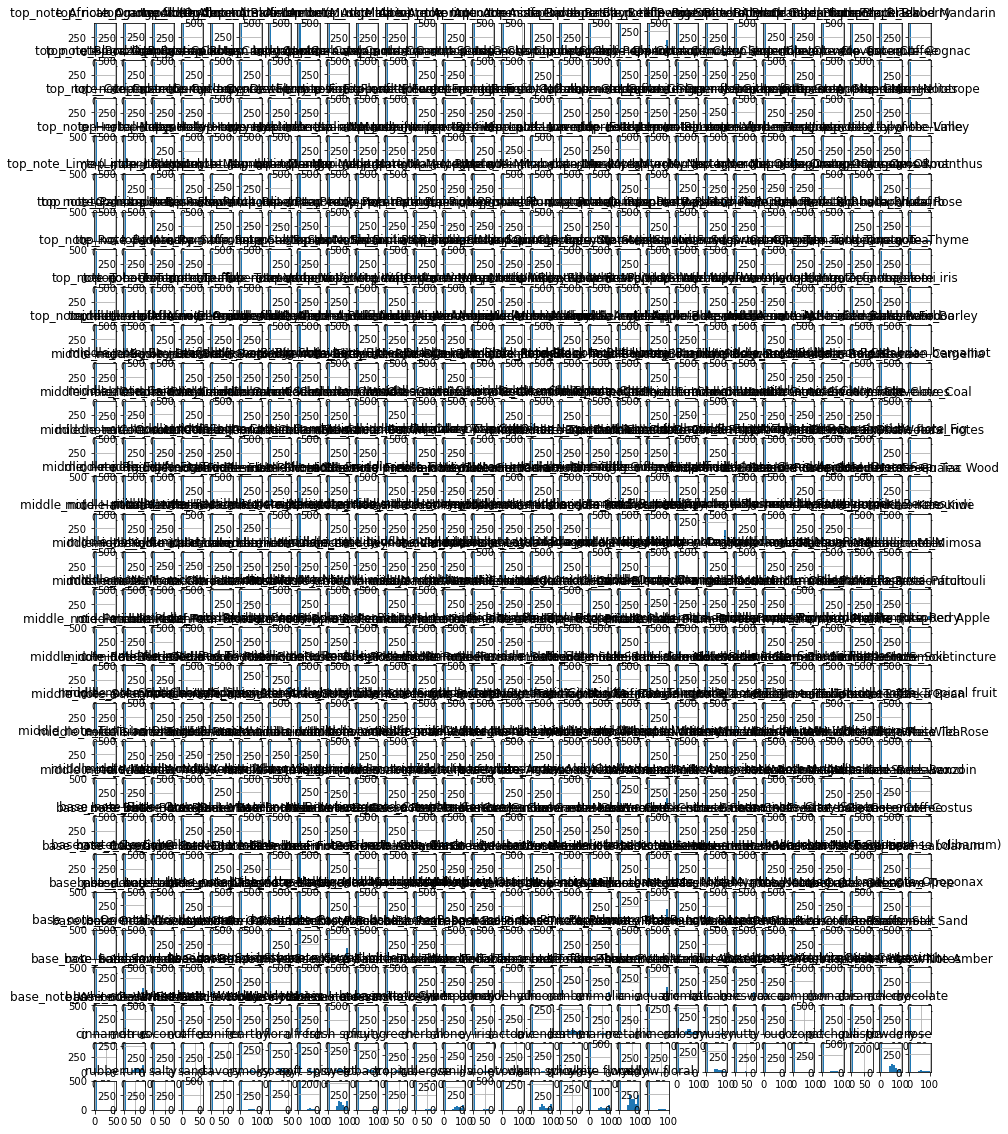

In [9]:
X.hist(figsize=(15,20))

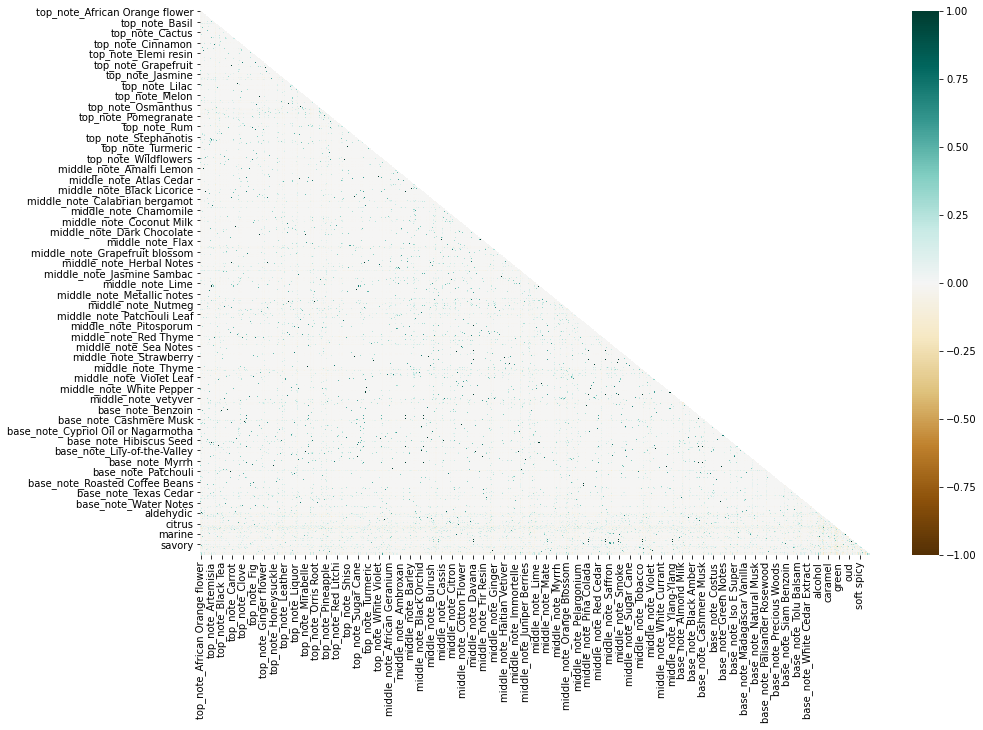

In [10]:
# heatmap to figure best features. Features that are more green are highly correlated and thus not a good option
plt.figure(figsize=(15,10))
mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))
heatmap = sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, cmap="BrBG")

In [11]:
# Finding the most important features using RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X, y)

importance_df = pd.DataFrame({"feature": X.columns, 
                              "Importance": rf.feature_importances_})
importance_df.sort_values("Importance", ascending=False)

,feature,Importance
774,aromatic,0.049530
791,fresh spicy,0.038122
830,woody,0.028066
829,white floral,0.027875
827,warm spicy,0.027609
...,...,...
735,base_note_Teak Wood,0.000000
745,base_note_Vanilla Absolute,0.000000
751,base_note_Water Hyacinth,0.000000
91,top_note_Honeysuckle,0.000000


## Train and Test data

In [12]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
# Create a MinMaxScaler model and fit it to the training data
X_scaler = MinMaxScaler().fit(X_train)

In [14]:
# Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
# Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

## SVC (Linear and RBF)

In [16]:
model = SVC()

# Fit model using GridSearchCV
param_grid = {'C': [1, 10, 50],
              'kernel': ('linear', 'rbf')}
grid = GridSearchCV(model, param_grid, verbose=3)
grid.fit(X_train_scaled, encoded_y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.708, total=   0.1s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.625, total=   0.1s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .................. C=1, kernel=linear, score=0.722, total=   0.1s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.690, total=   0.1s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.732, total=   0.1s
[CV] C=1, kernel=rbf .................................................
[CV] ..................... C=1, kernel=rbf, score=0.736, total=   0.1s
[CV] C=1, kernel=rbf .................................................
[CV] ..................... C=1, kernel=rbf, score=0.694, total=   0.1s
[CV] C=1, kernel=rbf .................................................
[CV] ..................... C=1, kernel=rbf, score=0.722, total=   0.1s
[CV] C=1, kernel=rbf .................................................
[CV] ..................... C=1, kernel=rbf, score=0.718, total=   0.1s
[CV] C=1, kernel=rbf .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.2s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 50], 'kernel': ('linear', 'rbf')},
             verbose=3)

In [17]:
# Model evaluation metrics
grid_score = grid.score(X_test_scaled, encoded_y_test)
print('Test Acc: %.3f' % grid_score)
predictions = grid.predict(X_test_scaled)
grid_report = classification_report(encoded_y_test, predictions,
                            target_names=target_names)
print(grid_report)
print(grid.best_params_)


Test Acc: 0.608
              precision    recall  f1-score   support

         Men       0.59      0.52      0.55        31
       Women       0.63      0.88      0.74        51
      Unisex       0.55      0.32      0.40        38

    accuracy                           0.61       120
   macro avg       0.59      0.57      0.56       120
weighted avg       0.60      0.61      0.58       120

{'C': 50, 'kernel': 'rbf'}


### KNearestNeighbor

k: 1, Train/Test Score: 0.983/0.550
k: 3, Train/Test Score: 0.799/0.500
k: 5, Train/Test Score: 0.698/0.492
k: 7, Train/Test Score: 0.637/0.458
k: 9, Train/Test Score: 0.601/0.442
k: 11, Train/Test Score: 0.584/0.425
k: 13, Train/Test Score: 0.567/0.433
k: 15, Train/Test Score: 0.564/0.425


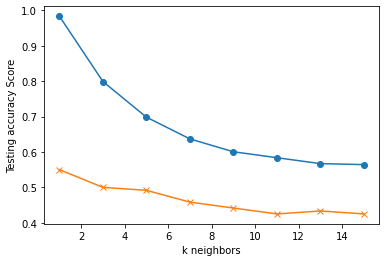

In [18]:
# Instantiate model 2 (KNeighborsClassifier)
train_scores = []
test_scores = []
for k in range(1, 16, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, encoded_y_train)
    train_score = knn.score(X_train_scaled, encoded_y_train)
    test_score = knn.score(X_test_scaled, encoded_y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 16, 2), train_scores, marker='o')
plt.plot(range(1, 16, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()


In [19]:
# Model evaluation metrics
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_scaled, encoded_y_train)
knn_score = knn.score(X_test_scaled, encoded_y_test)
print('k=11 Test Acc: %.3f' % knn_score)
predictions = knn.predict(X_test_scaled)
knn_report = classification_report(encoded_y_test, predictions,
                            target_names=target_names)
print(knn_report)


k=11 Test Acc: 0.425
              precision    recall  f1-score   support

         Men       0.00      0.00      0.00        31
       Women       0.43      1.00      0.60        51
      Unisex       0.00      0.00      0.00        38

    accuracy                           0.42       120
   macro avg       0.14      0.33      0.20       120
weighted avg       0.18      0.42      0.26       120



/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree

In [20]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_scaled, encoded_y_train)
clf_score = clf.score(X_test_scaled, encoded_y_test)
predictions = clf.predict(X_test_scaled)
print('Test Acc: %.3f' % clf_score)
clf_report = classification_report(encoded_y_test, predictions,
                            target_names=target_names)
print(clf_report)

Test Acc: 0.508
              precision    recall  f1-score   support

         Men       0.50      0.45      0.47        31
       Women       0.60      0.73      0.65        51
      Unisex       0.33      0.26      0.29        38

    accuracy                           0.51       120
   macro avg       0.48      0.48      0.47       120
weighted avg       0.49      0.51      0.49       120



### RandomForestTree

In [21]:
rf = RandomForestClassifier(n_estimators=100)
rf = rf.fit(X_train_scaled, encoded_y_train)
rf_score = rf.score(X_test_scaled, encoded_y_test)
predictions = rf.predict(X_test_scaled)
print('Test Acc: %.3f' % rf_score)
rf_report = classification_report(encoded_y_test, predictions,
                            target_names=target_names)
print(rf_report)

Test Acc: 0.558
              precision    recall  f1-score   support

         Men       0.59      0.52      0.55        31
       Women       0.55      0.92      0.69        51
      Unisex       0.50      0.11      0.17        38

    accuracy                           0.56       120
   macro avg       0.55      0.51      0.47       120
weighted avg       0.55      0.56      0.49       120



### Deep Learning Model

In [22]:
# Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [23]:
# Create model and add layers
dlnn = Sequential()
dlnn.add(Dense(units=50, activation='relu', input_dim=832))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=50, activation='relu'))
dlnn.add(Dense(units=3, activation='softmax'))

In [24]:
# Compile and fit the model
dlnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
dlnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                41650     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 49,453
Trainable params: 49,453
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = dlnn.fit(
    X_train_scaled,
    y_train_categorical,
    validation_data=(X_test_scaled, y_test_categorical),
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
12/12 - 1s - loss: 1.0416 - accuracy: 0.5531 - val_loss: 1.1445 - val_accuracy: 0.4250
Epoch 2/100
12/12 - 0s - loss: 0.9311 - accuracy: 0.5587 - val_loss: 1.2278 - val_accuracy: 0.4250
Epoch 3/100
12/12 - 0s - loss: 0.8423 - accuracy: 0.5587 - val_loss: 1.1575 - val_accuracy: 0.4250
Epoch 4/100
12/12 - 0s - loss: 0.7270 - accuracy: 0.5922 - val_loss: 1.0846 - val_accuracy: 0.5417
Epoch 5/100
12/12 - 0s - loss: 0.6011 - accuracy: 0.7989 - val_loss: 1.0408 - val_accuracy: 0.6417
Epoch 6/100
12/12 - 0s - loss: 0.4592 - accuracy: 0.8659 - val_loss: 1.0266 - val_accuracy: 0.6333
Epoch 7/100
12/12 - 0s - loss: 0.3118 - accuracy: 0.9162 - val_loss: 1.1089 - val_accuracy: 0.6167
Epoch 8/100
12/12 - 0s - loss: 0.1860 - accuracy: 0.9441 - val_loss: 1.3282 - val_accuracy: 0.6333
Epoch 9/100
12/12 - 0s - loss: 0.1162 - accuracy: 0.9721 - val_loss: 1.5130 - val_accuracy: 0.6333
Epoch 10/100
12/12 - 0s - loss: 0.0790 - accuracy: 0.9777 - val_loss: 1.8143 - val_accuracy: 0.6333
Epoch 11/

12/12 - 0s - loss: 0.0339 - accuracy: 0.9777 - val_loss: 3.3814 - val_accuracy: 0.6250
Epoch 84/100
12/12 - 0s - loss: 0.0333 - accuracy: 0.9832 - val_loss: 3.2478 - val_accuracy: 0.6250
Epoch 85/100
12/12 - 0s - loss: 0.0314 - accuracy: 0.9832 - val_loss: 3.2405 - val_accuracy: 0.6167
Epoch 86/100
12/12 - 0s - loss: 0.0339 - accuracy: 0.9832 - val_loss: 3.1551 - val_accuracy: 0.6167
Epoch 87/100
12/12 - 0s - loss: 0.0316 - accuracy: 0.9832 - val_loss: 3.2180 - val_accuracy: 0.6250
Epoch 88/100
12/12 - 0s - loss: 0.0316 - accuracy: 0.9832 - val_loss: 3.3191 - val_accuracy: 0.6250
Epoch 89/100
12/12 - 0s - loss: 0.0316 - accuracy: 0.9832 - val_loss: 3.2398 - val_accuracy: 0.6167
Epoch 90/100
12/12 - 0s - loss: 0.0312 - accuracy: 0.9832 - val_loss: 3.2508 - val_accuracy: 0.6167
Epoch 91/100
12/12 - 0s - loss: 0.0321 - accuracy: 0.9832 - val_loss: 3.2344 - val_accuracy: 0.6167
Epoch 92/100
12/12 - 0s - loss: 0.0316 - accuracy: 0.9832 - val_loss: 3.3608 - val_accuracy: 0.6333
Epoch 93/100


In [27]:
model_loss, model_accuracy = dlnn.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")


4/4 - 0s - loss: 3.3272 - accuracy: 0.6167
Normal Neural Network - Loss: 3.327179431915283, Accuracy: 0.6166666746139526


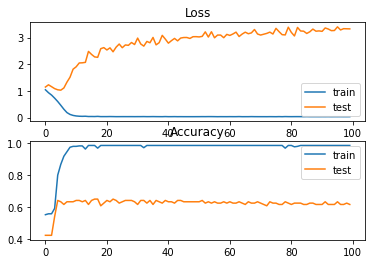

In [28]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

##### Save the Model

In [29]:
# import joblib
# final_model = dlnn
# filename = '../webapp/static/Resources/gender_perfume_model.sav'
# joblib.dump(final_model, filename)

dlnn.save("../webapp/static/Resources/Gender_Perfume_Model")


INFO:tensorflow:Assets written to: ../webapp/static/Resources/Gender_Perfume_Model/assets
